In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

print(f"Torch version: {torch.__version__}")

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Torch version: 2.9.1+cu128
Device: cpu


In [2]:
class Expert(nn.Module):
    """
    Expert module - Standard FFN
    Same architecture used in Mixtral
    """
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        
        self.w1 = nn.Linear(d_model, d_ff, bias=False)  # No bias in Mixtral
        self.w2 = nn.Linear(d_ff, d_model, bias=False)
        self.w3 = nn.Linear(d_model, d_ff, bias=False)  # Gating network
        
    def forward(self, x):
        """
        Mixtral uses SwiGLU activation:
        SwiGLU(x) = Swish(W1·x) ⊙ (W3·x) → W2
        
        Where Swish(x) = x * sigmoid(x)
        """
        # SwiGLU: combines gating and activation
        gate = F.silu(self.w1(x))  # SiLU = Swish
        up = self.w3(x)
        hidden = gate * up
        output = self.w2(hidden)
        
        return output

# Test Expert
d_model = 4096  # Mixtral uses larger dimensions
d_ff = 14336    # Mixtral 8x7B uses this
expert = Expert(d_model, d_ff)

x = torch.randn(10, d_model)
output = expert(x)
print(f"✓ Expert: {x.shape} → {output.shape}")
print(f"✓ Using SwiGLU activation")

✓ Expert: torch.Size([10, 4096]) → torch.Size([10, 4096])
✓ Using SwiGLU activation


In [3]:
class MixtralRouter(nn.Module):
    """
    Mixtral Router: Top-K Expert Selection
    
    Key Innovation of Mixtral:
    - Each token is processed by K experts (not just 1)
    - Top-K routing: pick best K experts per token
    - Weighted combination of expert outputs
    
    Example with K=2, 8 experts:
    Token → Router → [0.3, 0.05, 0.4, 0.1, 0.05, 0.05, 0.02, 0.03]
                  → Pick top-2: Expert 2 (0.4) and Expert 0 (0.3)
                  → Output = 0.57*Expert2 + 0.43*Expert0
    
    Benefits:
    ✓ Better capacity: K experts per token vs 1
    ✓ More stable: less affected by routing errors
    ✓ Smoother gradients
    """
    def __init__(self, d_model, num_experts, top_k=2):
        super().__init__()
        
        self.num_experts = num_experts
        self.top_k = top_k
        
        # Router network
        self.gate = nn.Linear(d_model, num_experts, bias=False)
        
    def forward(self, x):
        """
        Args:
            x: [batch, seq_len, d_model]
            
        Returns:
            top_k_indices: [batch, seq_len, top_k] - selected expert indices
            top_k_weights: [batch, seq_len, top_k] - normalized weights
            router_logits: [batch, seq_len, num_experts] - raw scores
        """
        batch_size, seq_len, d_model = x.shape
        
        # Compute router logits
        router_logits = self.gate(x)  # [batch, seq_len, num_experts]
        
        # Get top-k experts per token
        top_k_logits, top_k_indices = torch.topk(
            router_logits, 
            k=self.top_k, 
            dim=-1
        )  # Both: [batch, seq_len, top_k]
        
        # Normalize weights using softmax over top-k
        top_k_weights = F.softmax(top_k_logits, dim=-1)
        
        # Also return full probabilities for analysis
        router_probs = F.softmax(router_logits, dim=-1)
        
        return top_k_indices, top_k_weights, router_probs, router_logits

# Test Router
num_experts = 8
top_k = 2
router = MixtralRouter(d_model=512, num_experts=num_experts, top_k=top_k)

x = torch.randn(2, 10, 512)
top_k_indices, top_k_weights, router_probs, router_logits = router(x)

print(f"Input shape: {x.shape}")
print(f"Top-{top_k} indices: {top_k_indices.shape}")
print(f"Top-{top_k} weights: {top_k_weights.shape}")
print(f"\nFirst token routing:")
print(f"  All expert probs: {router_probs[0, 0]}")
print(f"  Top-{top_k} experts: {top_k_indices[0, 0]}")
print(f"  Top-{top_k} weights: {top_k_weights[0, 0]}")
print(f"  Weights sum: {top_k_weights[0, 0].sum():.4f}")
print(f"\n✓ Mixtral Router working!")

Input shape: torch.Size([2, 10, 512])
Top-2 indices: torch.Size([2, 10, 2])
Top-2 weights: torch.Size([2, 10, 2])

First token routing:
  All expert probs: tensor([0.2169, 0.0545, 0.1078, 0.1222, 0.1575, 0.1435, 0.0794, 0.1181],
       grad_fn=<SelectBackward0>)
  Top-2 experts: tensor([0, 4])
  Top-2 weights: tensor([0.5794, 0.4206], grad_fn=<SelectBackward0>)
  Weights sum: 1.0000

✓ Mixtral Router working!


In [4]:
class MixtralMoELayer(nn.Module):
    """
    Complete Mixtral MoE Layer
    
    Architecture (Mixtral 8x7B):
    - 8 experts, each is a 7B FFN
    - Top-2 routing: each token uses 2 experts
    - Total params: 47B (8×7B - shared attention)
    - Active params per token: 13B (7B base + 2×3.5B experts)
    
    This gives Mixtral its efficiency:
    - Quality of 47B model
    - Speed of 13B model
    """
    def __init__(
        self,
        d_model=4096,
        d_ff=14336,
        num_experts=8,
        top_k=2,
        dropout=0.1
    ):
        super().__init__()
        
        self.num_experts = num_experts
        self.top_k = top_k
        self.d_model = d_model
        
        # Router
        self.router = MixtralRouter(d_model, num_experts, top_k)
        
        # Experts
        self.experts = nn.ModuleList([
            Expert(d_model, d_ff, dropout) for _ in range(num_experts)
        ])
        
    def forward(self, x, return_router_info=False):
        """
        Args:
            x: [batch, seq_len, d_model]
            return_router_info: whether to return routing statistics
            
        Returns:
            output: [batch, seq_len, d_model]
            (optional) router_info: dict with routing details
        """
        batch_size, seq_len, d_model = x.shape
        
        # Route tokens
        top_k_indices, top_k_weights, router_probs, router_logits = self.router(x)
        
        # Flatten for processing
        x_flat = x.view(-1, d_model)  # [batch*seq_len, d_model]
        top_k_indices_flat = top_k_indices.view(-1, self.top_k)  # [batch*seq_len, top_k]
        top_k_weights_flat = top_k_weights.view(-1, self.top_k)  # [batch*seq_len, top_k]
        
        # Initialize output
        output_flat = torch.zeros_like(x_flat)
        
        # Process each token through its top-k experts
        for token_idx in range(x_flat.shape[0]):
            token_input = x_flat[token_idx:token_idx+1]  # [1, d_model]
            token_output = torch.zeros_like(token_input)
            
            # Process through top-k experts
            for k in range(self.top_k):
                expert_idx = top_k_indices_flat[token_idx, k].item()
                weight = top_k_weights_flat[token_idx, k]
                
                # Process through expert
                expert_output = self.experts[expert_idx](token_input)
                token_output += weight * expert_output
            
            output_flat[token_idx] = token_output
        
        # Reshape back
        output = output_flat.view(batch_size, seq_len, d_model)
        
        if return_router_info:
            # Compute expert utilization
            expert_counts = torch.zeros(self.num_experts, device=x.device)
            for k in range(self.top_k):
                for expert_idx in range(self.num_experts):
                    expert_counts[expert_idx] += (top_k_indices_flat[:, k] == expert_idx).sum()
            
            router_info = {
                'top_k_indices': top_k_indices,
                'top_k_weights': top_k_weights,
                'router_probs': router_probs,
                'expert_counts': expert_counts
            }
            return output, router_info
        
        return output

# Test Mixtral MoE
mixtral_moe = MixtralMoELayer(
    d_model=512,
    d_ff=2048,
    num_experts=8,
    top_k=2,
    dropout=0.1
)

x = torch.randn(2, 10, 512)
output, router_info = mixtral_moe(x, return_router_info=True)

print(f"Input:  {x.shape}")
print(f"Output: {output.shape}")
print(f"\nExpert utilization (top-{mixtral_moe.top_k} per token):")
total_selections = router_info['expert_counts'].sum()
for i in range(mixtral_moe.num_experts):
    count = router_info['expert_counts'][i].item()
    pct = count / total_selections * 100
    print(f"  Expert {i}: {count:3.0f} selections ({pct:5.1f}%)")
print(f"\n✓ Mixtral MoE working!")

Input:  torch.Size([2, 10, 512])
Output: torch.Size([2, 10, 512])

Expert utilization (top-2 per token):
  Expert 0:   8 selections ( 20.0%)
  Expert 1:   6 selections ( 15.0%)
  Expert 2:   3 selections (  7.5%)
  Expert 3:   0 selections (  0.0%)
  Expert 4:   3 selections (  7.5%)
  Expert 5:   7 selections ( 17.5%)
  Expert 6:   9 selections ( 22.5%)
  Expert 7:   4 selections ( 10.0%)

✓ Mixtral MoE working!


In [5]:
class RMSNorm(nn.Module):
    """
    RMS Normalization (used in Mixtral instead of LayerNorm)
    
    RMSNorm(x) = x / RMS(x) * γ
    where RMS(x) = sqrt(mean(x²))
    
    Simpler and faster than LayerNorm
    """
    def __init__(self, d_model, eps=1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(d_model))
        self.eps = eps
        
    def forward(self, x):
        # Compute RMS
        rms = torch.sqrt(torch.mean(x ** 2, dim=-1, keepdim=True) + self.eps)
        # Normalize and scale
        return x / rms * self.weight


class RotaryPositionalEmbedding(nn.Module):
    """
    RoPE (Rotary Position Embedding) - used in Mixtral
    Simpler implementation for demonstration
    """
    def __init__(self, d_model, max_seq_len=2048):
        super().__init__()
        self.d_model = d_model
        
    def forward(self, x):
        # Simplified: just return input
        # Full RoPE implementation is complex
        return x


class MixtralAttention(nn.Module):
    """
    Multi-head attention with Mixtral-specific modifications
    """
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.w_q = nn.Linear(d_model, d_model, bias=False)
        self.w_k = nn.Linear(d_model, d_model, bias=False)
        self.w_v = nn.Linear(d_model, d_model, bias=False)
        self.w_o = nn.Linear(d_model, d_model, bias=False)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        batch_size, seq_len, d_model = x.shape
        
        Q = self.w_q(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = self.w_k(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = self.w_v(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.d_k ** 0.5)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        
        out = torch.matmul(attn, V)
        out = out.transpose(1, 2).contiguous().view(batch_size, seq_len, d_model)
        out = self.w_o(out)
        
        return out


class MixtralTransformerLayer(nn.Module):
    """
    Complete Mixtral Transformer Layer
    
    Architecture:
    x → RMSNorm → Attention → Add → RMSNorm → MoE → Add → output
    
    Key differences from standard transformer:
    - RMSNorm instead of LayerNorm
    - MoE with Top-K routing
    - No bias terms in linear layers
    """
    def __init__(
        self,
        d_model=4096,
        num_heads=32,
        d_ff=14336,
        num_experts=8,
        top_k=2,
        dropout=0.1
    ):
        super().__init__()
        
        self.self_attn = MixtralAttention(d_model, num_heads, dropout)
        self.moe = MixtralMoELayer(d_model, d_ff, num_experts, top_k, dropout)
        
        self.attn_norm = RMSNorm(d_model)
        self.ffn_norm = RMSNorm(d_model)
        
    def forward(self, x, mask=None, return_router_info=False):
        # Self-attention block
        residual = x
        x = self.attn_norm(x)
        attn_out = self.self_attn(x, mask)
        x = residual + attn_out
        
        # MoE block
        residual = x
        x = self.ffn_norm(x)
        
        if return_router_info:
            moe_out, router_info = self.moe(x, return_router_info=True)
            x = residual + moe_out
            return x, router_info
        else:
            moe_out = self.moe(x)
            x = residual + moe_out
            return x

# Test complete Mixtral layer
mixtral_layer = MixtralTransformerLayer(
    d_model=512,
    num_heads=8,
    d_ff=2048,
    num_experts=8,
    top_k=2,
    dropout=0.1
)

x = torch.randn(2, 10, 512)
output, router_info = mixtral_layer(x, return_router_info=True)

print(f"Input:  {x.shape}")
print(f"Output: {output.shape}")
print(f"✓ Complete Mixtral Transformer layer working!")
print(f"✓ Using RMSNorm, Top-{mixtral_layer.moe.top_k} routing")

Input:  torch.Size([2, 10, 512])
Output: torch.Size([2, 10, 512])
✓ Complete Mixtral Transformer layer working!
✓ Using RMSNorm, Top-2 routing


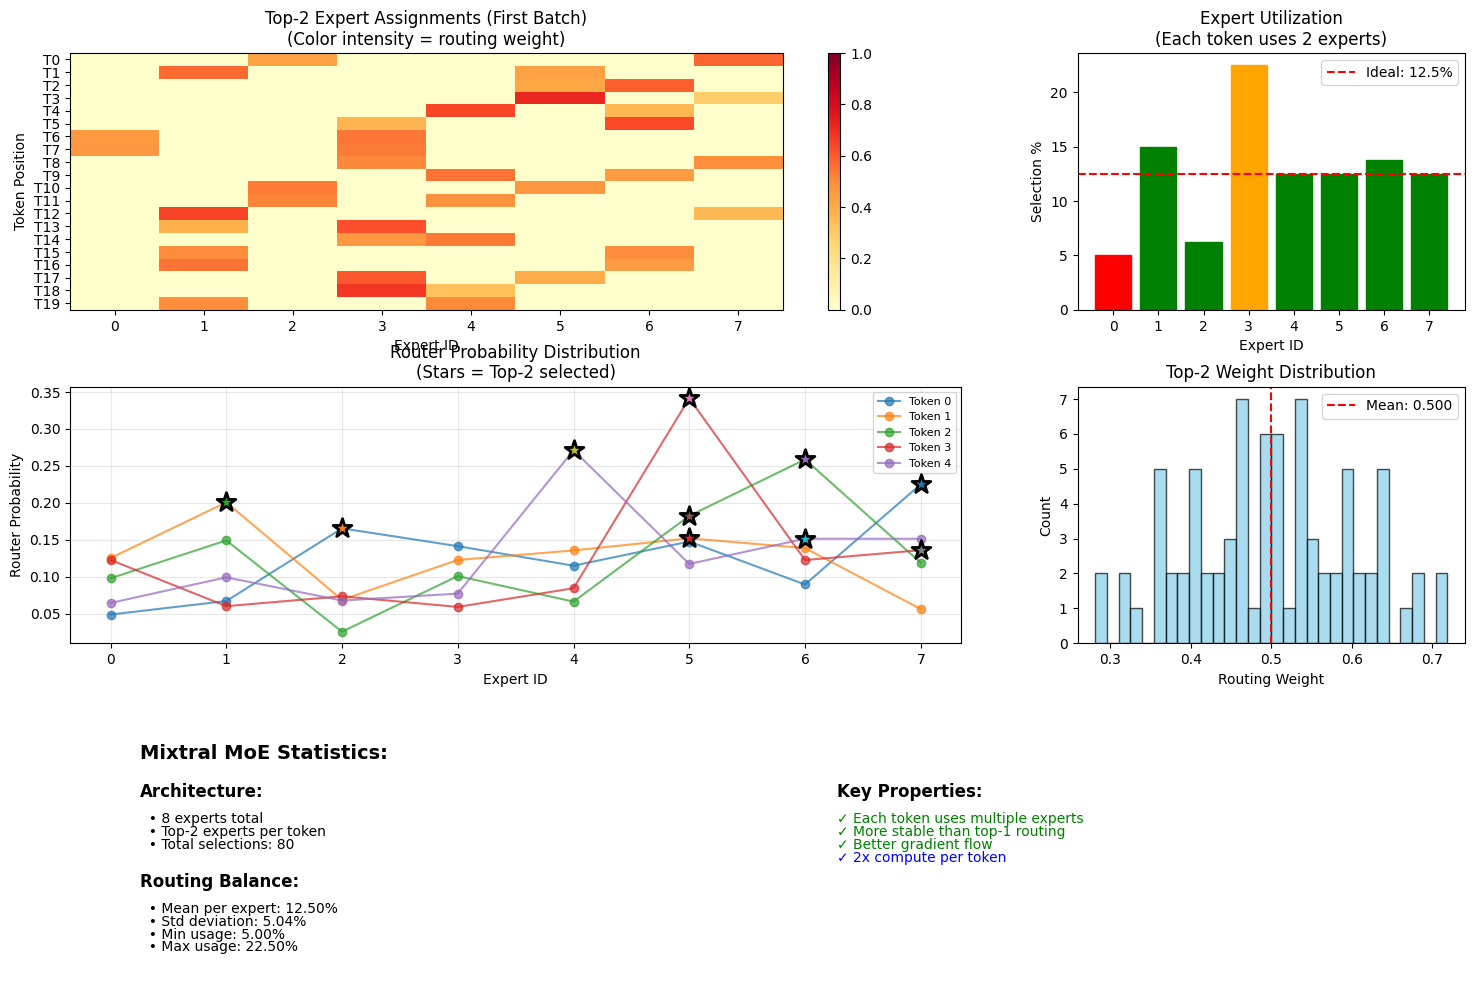


📊 Mixtral Routing Statistics:
Total tokens: 40
Experts: 8
Top-K: 2
Total expert invocations: 80

Expert Utilization:
  Expert 0: ██                          5.0% (  4 selections)
  Expert 1: ███████                    15.0% ( 12 selections)
  Expert 2: ███                         6.2% (  5 selections)
  Expert 3: ███████████                22.5% ( 18 selections)
  Expert 4: ██████                     12.5% ( 10 selections)
  Expert 5: ██████                     12.5% ( 10 selections)
  Expert 6: ██████                     13.8% ( 11 selections)
  Expert 7: ██████                     12.5% ( 10 selections)

Routing Weight Statistics:
  Mean: 0.5000
  Std:  0.1025
  Min:  0.2810
  Max:  0.7190


In [6]:
def visualize_mixtral_routing(model, x, token_labels=None):
    """
    Visualize Mixtral's Top-K routing pattern
    Shows how multiple experts process each token
    """
    moe_layer = model.moe if hasattr(model, 'moe') else model
    
    with torch.no_grad():
        _, router_info = moe_layer(x, return_router_info=True)
    
    batch_size, seq_len, _ = x.shape
    num_tokens = batch_size * seq_len
    num_experts = moe_layer.num_experts
    top_k = moe_layer.top_k
    
    top_k_indices = router_info['top_k_indices']
    top_k_weights = router_info['top_k_weights']
    router_probs = router_info['router_probs']
    expert_counts = router_info['expert_counts']
    
    # Create visualization
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # Plot 1: Expert assignment matrix (first batch)
    ax1 = fig.add_subplot(gs[0, :2])
    
    # Create matrix: tokens × experts, showing top-k assignments
    assignment_matrix = np.zeros((seq_len, num_experts))
    for t in range(seq_len):
        for k in range(top_k):
            expert_idx = top_k_indices[0, t, k].item()
            weight = top_k_weights[0, t, k].item()
            assignment_matrix[t, expert_idx] = weight
    
    im1 = ax1.imshow(assignment_matrix, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
    ax1.set_xlabel('Expert ID')
    ax1.set_ylabel('Token Position')
    ax1.set_title(f'Top-{top_k} Expert Assignments (First Batch)\n(Color intensity = routing weight)')
    plt.colorbar(im1, ax=ax1)
    
    if token_labels:
        ax1.set_yticks(range(len(token_labels)))
        ax1.set_yticklabels(token_labels)
    
    # Plot 2: Router probability distribution (first few tokens)
    ax2 = fig.add_subplot(gs[1, :2])
    
    # Show full probability distribution for first 5 tokens
    num_show = min(5, seq_len)
    for t in range(num_show):
        probs = router_probs[0, t].cpu().numpy()
        ax2.plot(range(num_experts), probs, marker='o', label=f'Token {t}', alpha=0.7)
        
        # Mark top-k experts
        for k in range(top_k):
            expert_idx = top_k_indices[0, t, k].item()
            ax2.scatter(expert_idx, probs[expert_idx], s=200, marker='*', 
                       edgecolors='black', linewidths=2, zorder=10)
    
    ax2.set_xlabel('Expert ID')
    ax2.set_ylabel('Router Probability')
    ax2.set_title(f'Router Probability Distribution\n(Stars = Top-{top_k} selected)')
    ax2.legend(loc='upper right', fontsize=8)
    ax2.grid(alpha=0.3)
    
    # Plot 3: Expert utilization
    ax3 = fig.add_subplot(gs[0, 2])
    
    expert_counts_np = expert_counts.cpu().numpy()
    total_selections = expert_counts_np.sum()
    expert_pcts = expert_counts_np / total_selections * 100
    
    bars = ax3.bar(range(num_experts), expert_pcts, edgecolor='black')
    ax3.axhline(y=100/num_experts, color='red', linestyle='--', 
                label=f'Ideal: {100/num_experts:.1f}%')
    ax3.set_xlabel('Expert ID')
    ax3.set_ylabel('Selection %')
    ax3.set_title(f'Expert Utilization\n(Each token uses {top_k} experts)')
    ax3.legend()
    
    # Color bars by utilization
    ideal = 100 / num_experts
    for i, (bar, pct) in enumerate(zip(bars, expert_pcts)):
        if pct < ideal * 0.5:
            bar.set_color('red')
        elif pct > ideal * 1.5:
            bar.set_color('orange')
        else:
            bar.set_color('green')
    
    # Plot 4: Weight distribution
    ax4 = fig.add_subplot(gs[1, 2])
    
    weights_flat = top_k_weights.view(-1).cpu().numpy()
    ax4.hist(weights_flat, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    ax4.axvline(weights_flat.mean(), color='red', linestyle='--', 
                label=f'Mean: {weights_flat.mean():.3f}')
    ax4.set_xlabel('Routing Weight')
    ax4.set_ylabel('Count')
    ax4.set_title(f'Top-{top_k} Weight Distribution')
    ax4.legend()
    
    # Plot 5: Key statistics
    ax5 = fig.add_subplot(gs[2, :])
    
    ax5.text(0.05, 0.85, "Mixtral MoE Statistics:", fontsize=14, weight='bold', 
             transform=ax5.transAxes)
    
    ax5.text(0.05, 0.70, f"Architecture:", fontsize=12, weight='bold', 
             transform=ax5.transAxes)
    ax5.text(0.05, 0.60, f"  • {num_experts} experts total", fontsize=10, 
             transform=ax5.transAxes)
    ax5.text(0.05, 0.55, f"  • Top-{top_k} experts per token", fontsize=10, 
             transform=ax5.transAxes)
    ax5.text(0.05, 0.50, f"  • Total selections: {total_selections:.0f}", fontsize=10, 
             transform=ax5.transAxes)
    
    ax5.text(0.05, 0.35, f"Routing Balance:", fontsize=12, weight='bold', 
             transform=ax5.transAxes)
    ax5.text(0.05, 0.25, f"  • Mean per expert: {expert_pcts.mean():.2f}%", fontsize=10, 
             transform=ax5.transAxes)
    ax5.text(0.05, 0.20, f"  • Std deviation: {expert_pcts.std():.2f}%", fontsize=10, 
             transform=ax5.transAxes)
    ax5.text(0.05, 0.15, f"  • Min usage: {expert_pcts.min():.2f}%", fontsize=10, 
             transform=ax5.transAxes)
    ax5.text(0.05, 0.10, f"  • Max usage: {expert_pcts.max():.2f}%", fontsize=10, 
             transform=ax5.transAxes)
    
    ax5.text(0.55, 0.70, "Key Properties:", fontsize=12, weight='bold', 
             transform=ax5.transAxes)
    ax5.text(0.55, 0.60, "✓ Each token uses multiple experts", fontsize=10, 
             color='green', transform=ax5.transAxes)
    ax5.text(0.55, 0.55, "✓ More stable than top-1 routing", fontsize=10, 
             color='green', transform=ax5.transAxes)
    ax5.text(0.55, 0.50, "✓ Better gradient flow", fontsize=10, 
             color='green', transform=ax5.transAxes)
    ax5.text(0.55, 0.45, f"✓ {top_k}x compute per token", fontsize=10, 
             color='blue', transform=ax5.transAxes)
    
    ax5.axis('off')
    
    plt.show()
    
    # Print detailed statistics
    print(f"\n📊 Mixtral Routing Statistics:")
    print(f"{'='*60}")
    print(f"Total tokens: {num_tokens}")
    print(f"Experts: {num_experts}")
    print(f"Top-K: {top_k}")
    print(f"Total expert invocations: {total_selections:.0f}")
    
    print(f"\nExpert Utilization:")
    for i in range(num_experts):
        count = expert_counts[i].item()
        pct = count / total_selections * 100
        bar = '█' * int(pct / 2)
        print(f"  Expert {i}: {bar:<25} {pct:5.1f}% ({count:3.0f} selections)")
    
    print(f"\nRouting Weight Statistics:")
    print(f"  Mean: {weights_flat.mean():.4f}")
    print(f"  Std:  {weights_flat.std():.4f}")
    print(f"  Min:  {weights_flat.min():.4f}")
    print(f"  Max:  {weights_flat.max():.4f}")

# Test visualization
mixtral_moe = MixtralMoELayer(d_model=512, num_experts=8, top_k=2)
x = torch.randn(2, 20, 512)
token_labels = [f"T{i}" for i in range(20)]

visualize_mixtral_routing(mixtral_moe, x, token_labels)

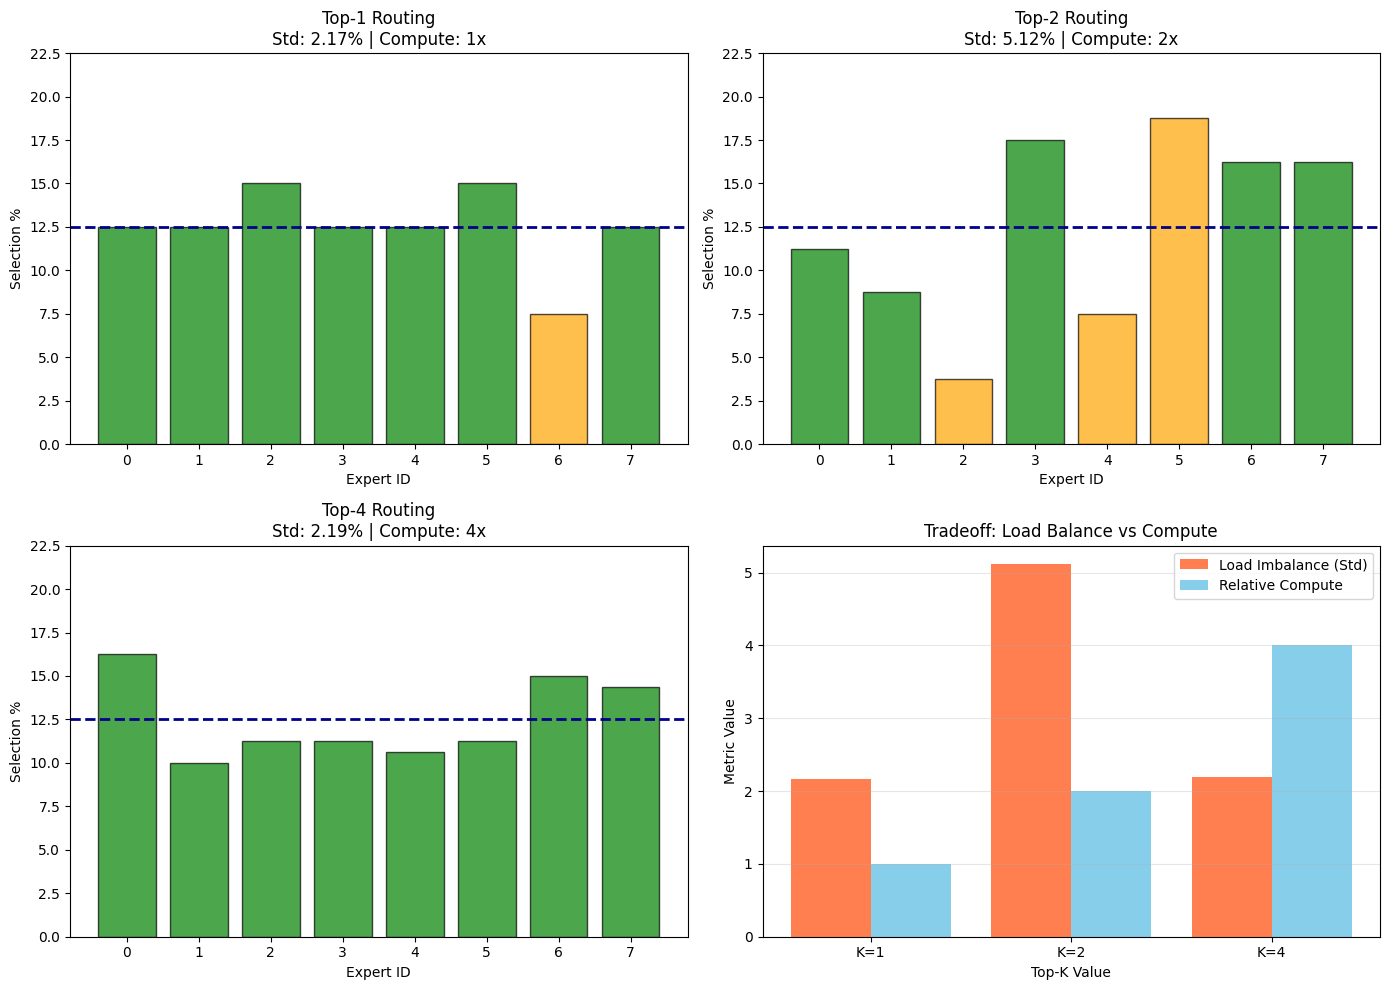


📊 Top-K Routing Comparison:
Top-K      Std Dev         Min %           Max %           Compute   
----------------------------------------------------------------------
K=1        2.17            7.50            15.00           1         x
K=2        5.12            3.75            18.75           2         x
K=4        2.19            10.00           16.25           4         x

Key Insights:
  • Higher K → Better load balance
  • Higher K → More compute per token
  • Mixtral uses K=2 as sweet spot
  • K=1 (Switch) can have routing collapse
  • K=4+ gives diminishing returns


In [7]:
def compare_topk_routing():
    """
    Compare different Top-K values
    Shows tradeoff between quality and compute
    """
    d_model = 512
    num_experts = 8
    x = torch.randn(2, 20, d_model)
    
    top_k_values = [1, 2, 4]
    results = {}
    
    for k in top_k_values:
        moe = MixtralMoELayer(d_model, 2048, num_experts, top_k=k)
        
        with torch.no_grad():
            _, router_info = moe(x, return_router_info=True)
        
        expert_counts = router_info['expert_counts'].cpu().numpy()
        total = expert_counts.sum()
        expert_pcts = expert_counts / total * 100
        
        results[k] = {
            'counts': expert_counts,
            'pcts': expert_pcts,
            'std': expert_pcts.std(),
            'compute': k  # Relative compute cost
        }
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot each Top-K
    for idx, k in enumerate(top_k_values):
        ax = axes[idx // 2, idx % 2]
        
        pcts = results[k]['pcts']
        colors = ['green' if 8 < p < 18 else 'orange' if p > 0 else 'red' for p in pcts]
        
        bars = ax.bar(range(num_experts), pcts, color=colors, alpha=0.7, edgecolor='black')
        ax.axhline(y=100/num_experts, color='darkblue', linestyle='--', linewidth=2)
        ax.set_xlabel('Expert ID')
        ax.set_ylabel('Selection %')
        ax.set_title(f'Top-{k} Routing\nStd: {results[k]["std"]:.2f}% | Compute: {k}x')
        ax.set_ylim(0, max([max(r['pcts']) for r in results.values()]) * 1.2)
    
    # Summary comparison
    ax = axes[1, 1]
    
    x_pos = np.arange(len(top_k_values))
    stds = [results[k]['std'] for k in top_k_values]
    computes = [results[k]['compute'] for k in top_k_values]
    
    ax.bar(x_pos - 0.2, stds, 0.4, label='Load Imbalance (Std)', color='coral')
    ax.bar(x_pos + 0.2, computes, 0.4, label='Relative Compute', color='skyblue')
    
    ax.set_xlabel('Top-K Value')
    ax.set_ylabel('Metric Value')
    ax.set_title('Tradeoff: Load Balance vs Compute')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([f'K={k}' for k in top_k_values])
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print comparison
    print(f"\n📊 Top-K Routing Comparison:")
    print(f"{'='*70}")
    print(f"{'Top-K':<10} {'Std Dev':<15} {'Min %':<15} {'Max %':<15} {'Compute':<10}")
    print(f"{'-'*70}")
    
    for k in top_k_values:
        r = results[k]
        print(f"{'K=' + str(k):<10} {r['std']:<15.2f} {r['pcts'].min():<15.2f} "
              f"{r['pcts'].max():<15.2f} {r['compute']:<10}x")
    
    print(f"\nKey Insights:")
    print(f"  • Higher K → Better load balance")
    print(f"  • Higher K → More compute per token")
    print(f"  • Mixtral uses K=2 as sweet spot")
    print(f"  • K=1 (Switch) can have routing collapse")
    print(f"  • K=4+ gives diminishing returns")

compare_topk_routing()